In [324]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

# Testing in parallel code

In [329]:
filename = "he_vmc_cas_5_nelecas_1_1.hdf5"
f = h5py.File(filename, "r")

In [330]:
f.keys()

<KeysViewHDF5 ['acceptance', 'block', 'configs', 'energycorr', 'energyee', 'energyei', 'energygrad2', 'energyii', 'energyka', 'energykb', 'energyke', 'energytotal', 'energyvh', 'energyvxc', 'excitationsdelta', 'excitationsovlp_ij', 'nconfig']>

In [331]:
def plot_delta_ovlp(filename="abvmc.hdf5", discard = 2):
    f = h5py.File(filename, "r")    

    fig, ax = plt.subplots(3, 2, figsize = (12, 15))    
    ovlp_ij_raw=np.array(f['excitationsovlp_ij'])
    delta_ij_raw=np.array(f['excitationsdelta'])
    discard = 2
    ovlp_ij = np.average(ovlp_ij_raw[discard:], axis=0)
    # plt.figure()
    sns.heatmap(ovlp_ij, ax=ax[0, 0]) #, annot=True)
    ax[0, 0].set_title('Overlap matrix')
    # plt.title('Overlap matrix')

    ovlp_ij_std = np.std(ovlp_ij_raw[discard:], axis=0)
    sns.heatmap(ovlp_ij_std, ax=ax[1, 0]) #, annot=True)
    ax[1, 0].set_title('Standard deviation of overlap matrix')
    
    filtered_ovlp_ij = copy.deepcopy(ovlp_ij)
    filtered_ovlp_ij[ovlp_ij_std>np.abs(ovlp_ij)] = 0
    sns.heatmap(filtered_ovlp_ij, ax=ax[2, 0]) #, annot=True)
    ax[2, 0].set_title('Filtered overlap matrix')
    


    delta_ij = np.average(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij, ax=ax[0, 1]) #, annot=True)
    ax[0, 1].set_title('Delta matrix')
                       
    delta_ij_std = np.std(delta_ij_raw[discard:], axis=0)
    sns.heatmap(delta_ij_std, ax=ax[1, 1]) #, annot=True)
    ax[1, 1].set_title('Standard deviation of delta matrix')
    

    filtered_delta_ij = copy.deepcopy(delta_ij)
    filtered_delta_ij[delta_ij_std>np.abs(delta_ij)] = 0
    sns.heatmap(filtered_delta_ij, ax=ax[2, 1]) #, annot=True)
    ax[2, 1].set_title('Filtered Delta matrix')
    
    return {'filtered': [filtered_ovlp_ij, filtered_delta_ij], 
            'raw': [ovlp_ij_raw, delta_ij_raw]}
# res = plot_delta_ovlp()

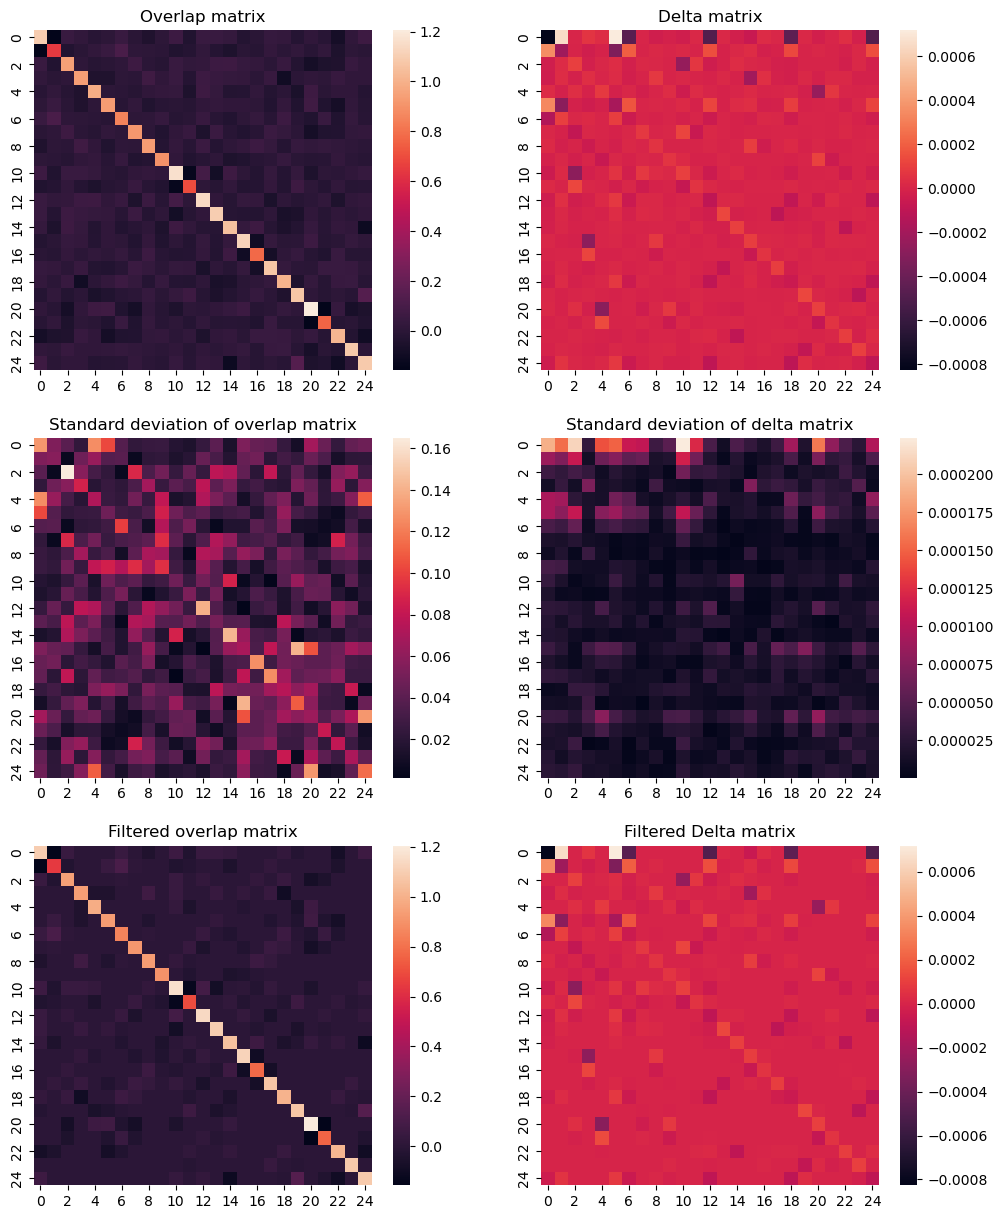

In [332]:
res = plot_delta_ovlp(filename, discard=0)
s, delta = res['filtered']
# sinv = np.linalg.inv(s)
# m = np.matmul(sinv, delta)
# e, v = np.linalg.eigh(m)
# (e-e[0]) * 27.211

In [333]:
s, delta = res['raw']
s[:, 0,0]

array([0.95734319, 0.98929959, 0.99103611, 1.27979894, 1.01757572])

In [334]:
def get_h_mf(ci_filename, ncore = (1,1), target_root = 0):
    f = h5py.File(ci_filename, "r")    
    ci = np.array(f['ci']['ci'][target_root])
    ncas = np.int32(f['ci']['ncas'])
    nelecas = list(np.array(f['ci']['nelecas']))
    try:
        ncore = list(np.array(f['ci']['ncore']))
    except:
        ncore = np.array(f['ci']['ncore'])
    print('Ncore: ', ncore)
    mo_coeff = np.array(f['ci']['mo_coeff'])
    mc_mo_energy = np.array(f['ci']['mc_mo_energy'])
    mf_mo_energy = np.array(f['ci']['mf_mo_energy'])
    f.close()
    import pyscf
    import determinant_tools

    deters = pyscf.fci.addons.large_ci(ci, ncas, nelecas, tol=-1)
    det = determinant_tools.reformat_binary_dets(deters, ncore=ncore, tol=-1)
    ncore = (ncore-1, ncore-1)
    mf_levels = []
    
    for d in det:
        c_i, orb_i = d
        orb_up = np.array(orb_i[0])
        orb_up = orb_up[orb_up>ncore[0]]
        orb_dn = np.array(orb_i[1])
        orb_dn = orb_dn[orb_dn>ncore[1]]
        mf_energy = np.sum(mf_mo_energy[0][orb_up]) + np.sum(mf_mo_energy[1][orb_dn])
        mf_levels.append(mf_energy)
        print(orb_up, orb_dn, mf_energy)
        # print(orb_i)
    d = {}
    d['mo_energy'] = mf_mo_energy
    return np.diag(mf_levels), d

def get_sigma(ci_filename, res):
    h_mf, _ = get_h_mf(ci_filename, target_root = 0)    
    s, delta = res['filtered']
    sigma = np.matmul(np.linalg.inv(s), delta)
    
    abvmc_eig, abvmc_eigv = np.linalg.eig(h_mf + sigma)
    # abvmc_eig = np.sort(abvmc_eig)
    # dft_eig = np.sort(np.diag(h_mf))    
    dft_eig = np.diag(h_mf)
    return abvmc_eig, dft_eig
    

In [335]:
abvmc_eig, dft_eig = get_sigma("he-ci.hdf5", res)
for i in range(abvmc_eig.shape[0]):
    abvmc_ref = np.real(abvmc_eig[0])
    dft_ref = dft_eig[0]
    print(27.211*(np.real(abvmc_eig[i])-abvmc_ref), 27.211*(dft_eig[i]-dft_ref))

Ncore:  0
[0] [0] -1.1388936381508066
[0] [1] -0.220932553275557
[0] [2] 0.25417309021231005
[0] [3] 0.25417309021231405
[0] [4] 0.25417309021231693
[1] [0] -0.220932553275557
[1] [1] 0.6970285315996926
[1] [2] 1.1721341750875596
[1] [3] 1.1721341750875636
[1] [4] 1.1721341750875665
[2] [0] 0.25417309021231005
[2] [1] 1.1721341750875596
[2] [2] 1.6472398185754267
[2] [3] 1.6472398185754307
[2] [4] 1.6472398185754336
[3] [0] 0.25417309021231405
[3] [1] 1.1721341750875636
[3] [2] 1.6472398185754307
[3] [3] 1.6472398185754347
[3] [4] 1.6472398185754376
[4] [0] 0.25417309021231693
[4] [1] 1.1721341750875665
[4] [2] 1.6472398185754336
[4] [3] 1.6472398185754376
[4] [4] 1.6472398185754404
0.0 0.0
24.98350204462531 24.978639080540415
25.001610664663964 37.90673874548877
49.974427111441834 37.90673874548887
37.93561145218765 37.90673874548895
37.93337304341617 24.978639080540415
37.93444918551657 49.95727816108083
37.92047385536071 62.88537782602918
37.92155825634712 62.885377826029284
37.9215